In [138]:
from IPython.display import Image
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import os
import itertools
import termcolor
from termcolor import colored

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import pylab

from collections import defaultdict
from IPython.display import Image


In [2]:
def read_file(filename):
        string = open(filename, "r").read()
        string_list = string.split("\n")
        string_list = [line for line in string_list if line and line[0] != '#'] #Read line only if it is nonempty and not a comment.
        return string_list

In [3]:
results_folder = '../output/'
other_tools = '../../../results/eval/'
greedy_contig_chains = '../../../results/output/hyasp/'

In [4]:
EFAECIUM = [15,16]
ECOLI = [18,19,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,52]
KPNEUMONIAE = [62,64,65,66,76,85,86,87]
OTHER = [1,5,55,56,102,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,129,133]

In [5]:
#Overall stats; key:sample_id, values: precision, recall, f1, total_length
MILP_STATS = {}
HYASP_STATS= {}
PLASMIDSPADES_STATS = {}
MOBSUITE_STATS = {}
GPLAS_STATS = {}

#Precision by sample; key:sample_id, values: precision_ratio, precision_by_length, total_length
MILP_PREC = {}
HYASP_PREC= {}
PLASMIDSPADES_PREC = {}
MOBSUITE_PREC = {}
GPLAS_PREC = {}

#Precision by plasmid; key: sample_id_plasmid_id, values: precision_ratio, precision_by_length, order of output, gene density, length
MILP_PREC_PLASMID = {}
HYASP_PREC_PLASMID= {}
PLASMIDSPADES_PREC_PLASMID = {}
MOBSUITE_PREC_PLASMID= {}
GPLAS_PREC_PLASMID = {}

#Recall by sample; key:sample_id, values: recall_ratio, recall_by_length
MILP_REC = {}
HYASP_REC= {}
PLASMIDSPADES_REC = {}
MOBSUITE_REC = {}
GPLAS_REC = {}

#True plasmid length; key: plasmid_id, values: length
TP_LENGTH = {}

In [6]:
def read_eval_file(str_list, sample_id, tool):
    #print(str_list)
    #print(tool)
    #print(sample_id)
    stats = {}
    prec = {}
    prec_individual = {}
    rec = {}
    tp_length = {}

    d1 = 'number'
    d2 = '>'
    delim_count = 0
    
     
    #Overall stats
    precision, recall, f1, total_len, pred_len = 0, 0, 0, 0, 0 
    putative_stats_obtained = 0
    
    for line in str_list:
        #print(line)
        if d1 in line or d2 in line:
            delim_count += 1   
        #True plasmids & their lengths    
        if delim_count == 2:
            if 'nt' in line:
                line = line[1:].split(" ")
                plas = line[0][:-1]
                length = int(line[1])
                tp_length[plas] = length
        #Predicted plasmids & their lengths       
        elif delim_count == 3: 
            if 'nt' in line:
                line = line[1:].split(" ")
                plas = line[0][:-1]
                length = int(line[1])
                #output_order = int(plas.split('_')[1])
                prec_individual['sample_'+sample_id+'_'+plas] = {}
                prec_individual['sample_'+sample_id+'_'+plas]['Length'] = length
                #prec_individual['sample_'+sample_id+'_'+plas]['Order'] = output_order
                prec_individual['sample_'+sample_id+'_'+plas]['Sample'] = sample_id
                
        #Precision per plasmid        
        elif delim_count == 6:
            if '_' in line:    
                line = line.split("\t")
                plas = line[0]
                length = prec_individual['sample_'+sample_id+'_'+plas]['Length']
                prec_individual['sample_'+sample_id+'_'+plas]['Precision_length'] = length*float(line[1])
                prec_individual['sample_'+sample_id+'_'+plas]['Precision'] = float(line[1])
        #Recall per true plasmid
        #elif delim_count == 7:
        #    if '.' in line:    
        #        line = line.split("\t")
        #        p = line[0]
        #        length = tp_length[p]
        #        rec[p] = {}
        #        rec[p]['Recall'] = float(line[1])
        #        rec[p]['Recall_length'] = length*float(line[1])
        
        if putative_stats_obtained == 0:
            if "precision" in line:
                precision = float(line.split(" ")[-1])
            stats['Precision'] = precision
            prec['Precision'] = precision
            if "recall" in line:    
                recall = float(line.split(" ")[-1])
            stats['Recall'] = recall
            rec['Recall'] = recall
            if "f1_score" in line:
                f1 = float(line.split(" ")[-1])
                putative_stats_obtained = 1
            stats['F1'] = f1
        
           
    for p in tp_length:
        total_len += tp_length[p]
    stats['Length'] = total_len
    rec['Length'] = total_len
    rec['Recall_length'] = rec['Recall']*total_len  
        
    for p in prec_individual:
        pred_len += prec_individual[p]['Length']
    prec['Precision_length'] = prec['Precision']*pred_len   
    prec['Length'] = pred_len
        
    #print(prec_individual)    
            
    return stats, prec, rec, prec_individual, tp_length   

In [7]:
#def get_true_plasmid_details(str_list, plasmids_dict):
def get_plasmid_gd(str_list, plasmids, sample_id):
    for line in str_list:
        if line[0] == '>':
            line = line.split("\t")
            #print(line)
            p = 'sample_'+sample_id+'_'+line[0][1:]
            #print(p)
            for i in range(len(line)):
                if 'gene_density' in line[i]:
                    gd = float(line[i].split('=')[1])
            plasmids[p]['Gene_density'] = gd
    return plasmids  

In [8]:
gplas_ids = EFAECIUM + ECOLI + KPNEUMONIAE
all_ids = gplas_ids + OTHER
sp_array = []
for i in all_ids:
    #print(i)
    if i in set(EFAECIUM):
        sp_array.append('E. faecium')
    elif i in set(ECOLI):
        sp_array.append('E. coli')
    elif i in set(KPNEUMONIAE):
        sp_array.append('K. pneumoniae')
    elif i == 1:
        sp_array.append('A. veronii')
    elif i == 5:
        sp_array.append('C. freundii')
    elif i == 55:
        sp_array.append('K. aerogenes')
    elif i == 56:
        sp_array.append('K. oxytoca')
    else:
        sp_array.append('S. enterica')
    sample_id = str(i)
    
    mobsuite_eval_file = other_tools+'sample_'+sample_id+'/mob_recon_eval.csv'
    str_list = read_file(mobsuite_eval_file)
    MOBSUITE_STATS[sample_id], MOBSUITE_PREC[sample_id], MOBSUITE_REC[sample_id], prec_sample, tplen_sample = read_eval_file(str_list,sample_id,'MOBSUITE')
    MOBSUITE_PREC_PLASMID.update(prec_sample)    
    
    plasmidspades_eval_file = other_tools+'sample_'+sample_id+'/plasmidspades_eval.csv'
    str_list = read_file(plasmidspades_eval_file)
    PLASMIDSPADES_STATS[sample_id], PLASMIDSPADES_PREC[sample_id], PLASMIDSPADES_REC[sample_id], prec_sample, tplen_sample = read_eval_file(str_list,sample_id,'PLASMIDSPADES')
    PLASMIDSPADES_PREC_PLASMID.update(prec_sample)

        
    
    MILP_eval_file = results_folder+'sample_'+sample_id+'/1.1.1/nplasmids_1/eval/MILP/MILP_eval.csv'
    str_list = read_file(MILP_eval_file)
    prec_sample = {}
    tplen_sample = {}

    MILP_STATS[sample_id], MILP_PREC[sample_id], MILP_REC[sample_id], prec_sample, tplen_sample = read_eval_file(str_list,sample_id,'MILP')
    MILP_PREC_PLASMID.update(prec_sample)
    TP_LENGTH.update(tplen_sample)
    
    #greedy_eval_file = results_folder+'sample_'+sample_id+'/1.1.1/nplasmids_1/eval/MILP/greedy_eval.csv'
    greedy_eval_file = other_tools+'sample_'+sample_id+'/greedy_eval.csv'
    str_list = read_file(greedy_eval_file)
    HYASP_STATS[sample_id], HYASP_PREC[sample_id], HYASP_REC[sample_id], prec_sample, tplen_sample = read_eval_file(str_list,sample_id,'GPLAS')
    HYASP_PREC_PLASMID.update(prec_sample)
    
    if i in set(gplas_ids):
        gplas_eval_file = other_tools+'sample_'+sample_id+'/gplas_eval.csv'
        str_list = read_file(gplas_eval_file)
        GPLAS_STATS[sample_id], GPLAS_PREC[sample_id], GPLAS_REC[sample_id], prec_sample, tplen_sample = read_eval_file(str_list,sample_id,'GPLAS')
        GPLAS_PREC_PLASMID.update(prec_sample)    
    
    MILP_gd_file = results_folder+'sample_'+sample_id+'/1.1.1/nplasmids_1/MILP/MILP_putative_plasmids.fasta'
    str_list = read_file(MILP_gd_file)
    
    MILP_PREC_PLASMID = get_plasmid_gd(str_list, MILP_PREC_PLASMID, sample_id)
#print(MILP_PREC_PLASMID)    

In [9]:
GPLAS_DF = pd.DataFrame.from_dict(GPLAS_STATS).T
GPLAS_DF

,Precision,Recall,F1,Length
15,0.939058,0.644789,0.764587,430944.0
16,0.889965,0.749392,0.813652,279233.0
18,0.931778,0.525981,0.672399,303199.0
19,1.000000,0.374807,0.545251,208131.0
23,0.218030,0.810021,0.343580,37362.0
24,1.000000,0.650730,0.788415,458871.0
25,1.000000,0.526554,0.689860,177752.0
26,1.000000,0.881437,0.936983,116529.0
27,1.000000,0.370293,0.540458,300203.0
28,1.000000,0.976471,0.988095,215053.0


In [10]:
MILP_DF = pd.DataFrame.from_dict(MILP_STATS).T
HYASP_DF = pd.DataFrame.from_dict(HYASP_STATS).T
PLASMIDSPADES_DF = pd.DataFrame.from_dict(PLASMIDSPADES_STATS).T
MOBSUITE_DF = pd.DataFrame.from_dict(MOBSUITE_STATS).T
GPLAS_DF = pd.DataFrame.from_dict(GPLAS_STATS).T

HYASP_DF = HYASP_DF.drop(columns=['Length'])
PLASMIDSPADES_DF = PLASMIDSPADES_DF.drop(columns=['Length'])
MOBSUITE_DF = MOBSUITE_DF.drop(columns=['Length'])
GPLAS_DF = GPLAS_DF.drop(columns=['Length'])

HYASP_DF = HYASP_DF.rename(columns={"Precision": "greedy_Precision", "Recall": "greedy_Recall", "F1": "greedy_F1"})
PLASMIDSPADES_DF = PLASMIDSPADES_DF.rename(columns={"Precision": "plasmidspades_Precision", "Recall": "plasmidspades_Recall", "F1": "plasmidspades_F1"})
MOBSUITE_DF = MOBSUITE_DF.rename(columns={"Precision": "mobsuite_Precision", "Recall": "mobsuite_Recall", "F1": "mobsuite_F1"})
GPLAS_DF = GPLAS_DF.rename(columns={"Precision": "gplas_Precision", "Recall": "gplas_Recall", "F1": "gplas_F1"})

ALL_DF = MILP_DF.join(HYASP_DF)
ALL_DF = ALL_DF.join(PLASMIDSPADES_DF)
ALL_DF = ALL_DF.join(MOBSUITE_DF)
ALL_DF = pd.concat([ALL_DF, GPLAS_DF], axis=1)

In [11]:
ALL_DF

,Precision,Recall,F1,Length,greedy_Precision,greedy_Recall,greedy_F1,plasmidspades_Precision,plasmidspades_Recall,plasmidspades_F1,mobsuite_Precision,mobsuite_Recall,mobsuite_F1,gplas_Precision,gplas_Recall,gplas_F1
15,0.790326,0.873603,0.829881,430944.0,0.821772,0.887039,0.853159,0.368280,0.620656,0.462265,0.820206,0.071675,0.131830,0.939058,0.644789,0.764587
16,0.936455,0.901358,0.918572,279233.0,0.780277,0.444378,0.566262,0.628124,0.728667,0.674670,0.756595,0.235635,0.359352,0.889965,0.749392,0.813652
18,0.932611,0.680263,0.786696,303199.0,0.863240,0.601786,0.709183,0.547593,0.503461,0.524601,0.875816,0.212761,0.342355,0.931778,0.525981,0.672399
19,0.916418,0.996709,0.954879,208131.0,0.832212,0.969495,0.895623,0.999130,0.543754,0.704241,1.000000,0.933239,0.965467,1.000000,0.374807,0.545251
23,0.018301,0.040496,0.025209,37362.0,0.291949,1.000000,0.451951,0.085292,1.000000,0.157178,1.000000,0.809807,0.894910,0.218030,0.810021,0.343580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1.000000,1.000000,1.000000,39793.0,1.000000,0.947327,0.972951,1.000000,0.947327,0.972951,1.000000,1.000000,1.000000,NaN,NaN,NaN
123,1.000000,1.000000,1.000000,37696.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN
124,1.000000,1.000000,1.000000,37696.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN
129,0.999937,0.993241,0.996578,322518.0,1.000000,0.996313,0.998153,0.829136,0.981480,0.898899,1.000000,0.336502,0.503556,NaN,NaN,NaN


## Distribution of plasmid lengths

### By sample: cumulative length of all plasmids in the sample

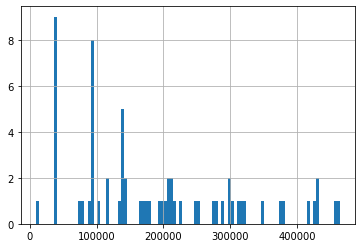

In [12]:
hist = ALL_DF['Length'].hist(bins=100)

### By plasmid: individual length of plasmids

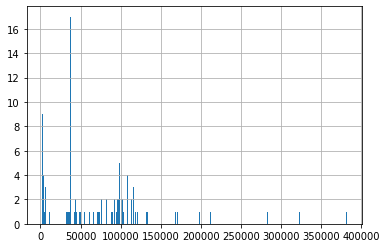

In [13]:
TPLEN_DF = pd.DataFrame(TP_LENGTH, index=['Length']).T
hist = TPLEN_DF['Length'].hist(bins=500)

## Precision, Recall and F1

In [14]:
ALL_DF['Category'] = ALL_DF['Length']//100000
ALL_DF['Species'] = sp_array

In [15]:
ALL_DF

,Precision,Recall,F1,Length,greedy_Precision,greedy_Recall,greedy_F1,plasmidspades_Precision,plasmidspades_Recall,plasmidspades_F1,mobsuite_Precision,mobsuite_Recall,mobsuite_F1,gplas_Precision,gplas_Recall,gplas_F1,Category,Species
15,0.790326,0.873603,0.829881,430944.0,0.821772,0.887039,0.853159,0.368280,0.620656,0.462265,0.820206,0.071675,0.131830,0.939058,0.644789,0.764587,4.0,E. faecium
16,0.936455,0.901358,0.918572,279233.0,0.780277,0.444378,0.566262,0.628124,0.728667,0.674670,0.756595,0.235635,0.359352,0.889965,0.749392,0.813652,2.0,E. faecium
18,0.932611,0.680263,0.786696,303199.0,0.863240,0.601786,0.709183,0.547593,0.503461,0.524601,0.875816,0.212761,0.342355,0.931778,0.525981,0.672399,3.0,E. coli
19,0.916418,0.996709,0.954879,208131.0,0.832212,0.969495,0.895623,0.999130,0.543754,0.704241,1.000000,0.933239,0.965467,1.000000,0.374807,0.545251,2.0,E. coli
23,0.018301,0.040496,0.025209,37362.0,0.291949,1.000000,0.451951,0.085292,1.000000,0.157178,1.000000,0.809807,0.894910,0.218030,0.810021,0.343580,0.0,E. coli
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1.000000,1.000000,1.000000,39793.0,1.000000,0.947327,0.972951,1.000000,0.947327,0.972951,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.0,S. enterica
123,1.000000,1.000000,1.000000,37696.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.0,S. enterica
124,1.000000,1.000000,1.000000,37696.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,0.0,S. enterica
129,0.999937,0.993241,0.996578,322518.0,1.000000,0.996313,0.998153,0.829136,0.981480,0.898899,1.000000,0.336502,0.503556,NaN,NaN,NaN,3.0,S. enterica


In [16]:
THREE_SPECIES_DF = ALL_DF[:len(gplas_ids)]

In [17]:
print("MILP\t\tHyAsP\t\tPlasmidSPAdes\tMOB-suite\tgplas")
print(THREE_SPECIES_DF['Precision'].mean(),"\t",THREE_SPECIES_DF['greedy_Precision'].mean(),"\t",THREE_SPECIES_DF['plasmidspades_Precision'].mean(),"\t",THREE_SPECIES_DF['mobsuite_Precision'].mean(),"\t",THREE_SPECIES_DF['gplas_Precision'].mean())
print(THREE_SPECIES_DF['Recall'].mean(),"\t",THREE_SPECIES_DF['greedy_Recall'].mean(),"\t",THREE_SPECIES_DF['plasmidspades_Recall'].mean(),"\t",THREE_SPECIES_DF['mobsuite_Recall'].mean(),"\t",THREE_SPECIES_DF['gplas_Recall'].mean())
print(THREE_SPECIES_DF['F1'].mean(),"\t",THREE_SPECIES_DF['greedy_F1'].mean(),"\t",THREE_SPECIES_DF['plasmidspades_F1'].mean(),"\t",THREE_SPECIES_DF['mobsuite_F1'].mean(),"\t",THREE_SPECIES_DF['gplas_F1'].mean())


MILP		HyAsP		PlasmidSPAdes	MOB-suite	gplas
0.788704225 	 0.820195025 	 0.678242 	 0.8349601 	 0.9350080500000001
0.843782275 	 0.817647125 	 0.754786575 	 0.490646075 	 0.7143217749999999
0.804501725 	 0.796680375 	 0.6451951250000001 	 0.5759532 	 0.791088225


In [18]:
print("MILP\t\tHyAsP\t\tPlasmidSPAdes\tMOB-suite")
print(ALL_DF['Precision'].mean(),"\t",ALL_DF['greedy_Precision'].mean(),"\t",ALL_DF['plasmidspades_Precision'].mean(),"\t",ALL_DF['mobsuite_Precision'].mean())
print(ALL_DF['Recall'].mean(),"\t",ALL_DF['greedy_Recall'].mean(),"\t",ALL_DF['plasmidspades_Recall'].mean(),"\t",ALL_DF['mobsuite_Recall'].mean())
print(ALL_DF['F1'].mean(),"\t",ALL_DF['greedy_F1'].mean(),"\t",ALL_DF['plasmidspades_F1'].mean(),"\t",ALL_DF['mobsuite_F1'].mean())


MILP		HyAsP		PlasmidSPAdes	MOB-suite
0.8589648615384616 	 0.8731318461538461 	 0.7431504461538462 	 0.8689268769230769
0.8843138615384616 	 0.8554549076923077 	 0.8206239076923076 	 0.6444134769230769
0.8600738615384615 	 0.8492378923076923 	 0.7237309076923077 	 0.6860061846153845


/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


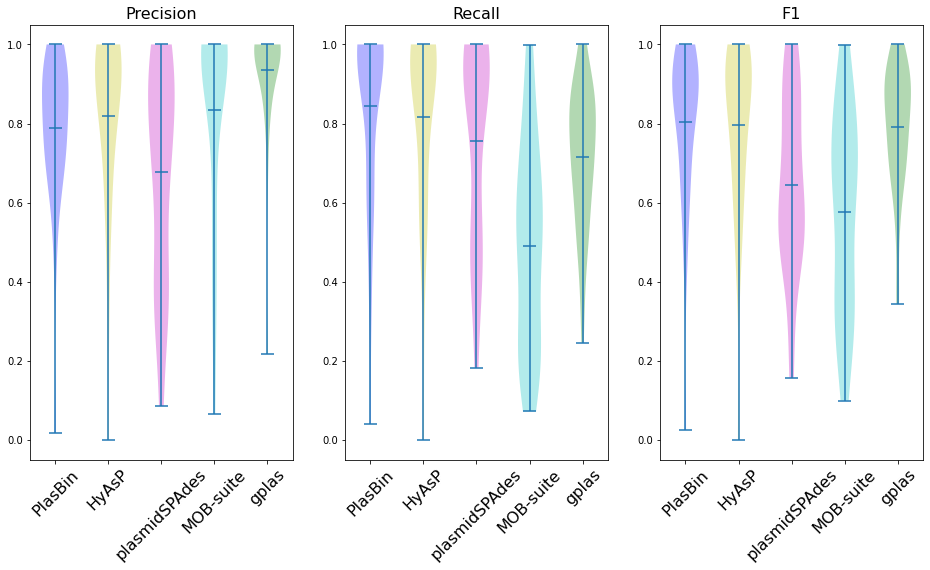

In [19]:
colors = ['b', 'y', 'm', 'c', 'g']
labels = ['','PlasBin', 'HyAsP', 'plasmidSPAdes', 'MOB-suite', 'gplas']
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
bplot1 = ax1.violinplot(THREE_SPECIES_DF[['Precision', 'greedy_Precision', 'plasmidspades_Precision', 'mobsuite_Precision', 'gplas_Precision']], showmeans=True)
ax1.set_title('Precision',fontsize=16)

bplot2 = ax2.violinplot(THREE_SPECIES_DF[['Recall', 'greedy_Recall', 'plasmidspades_Recall', 'mobsuite_Recall', 'gplas_Recall']], showmeans=True)
ax2.set_title('Recall',fontsize=16)
bplot3 = ax3.violinplot(THREE_SPECIES_DF[['F1', 'greedy_F1', 'plasmidspades_F1', 'mobsuite_F1', 'gplas_F1']], showmeans=True)
ax3.set_title('F1',fontsize=16)

for bplot in (bplot1, bplot2, bplot3):
    for pc, color in zip(bplot['bodies'], colors):
        pc.set_facecolor(color)

for ax in [ax1, ax2, ax3]:
    ax.set_xticklabels(labels, rotation=45, fontsize=16)

plt.show()
plt.close()

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


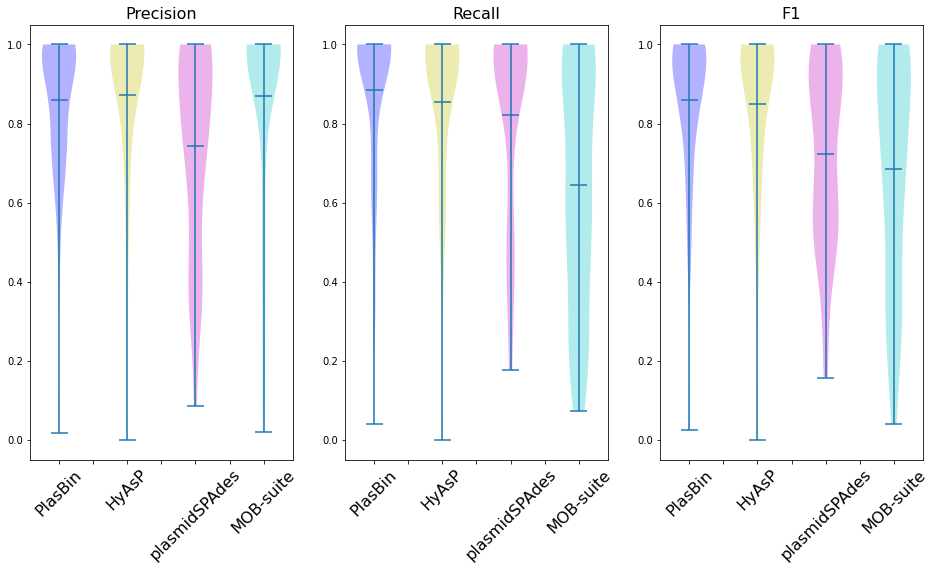

In [20]:
colors = ['b', 'y', 'm', 'c']
labels = ['','PlasBin','','HyAsP','','plasmidSPAdes','', 'MOB-suite']
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
bplot1 = ax1.violinplot(ALL_DF[['Precision', 'greedy_Precision', 'plasmidspades_Precision', 'mobsuite_Precision']], showmeans=True)
ax1.set_title('Precision',fontsize=16)

bplot2 = ax2.violinplot(ALL_DF[['Recall', 'greedy_Recall', 'plasmidspades_Recall', 'mobsuite_Recall']], showmeans=True)
ax2.set_title('Recall',fontsize=16)
bplot3 = ax3.violinplot(ALL_DF[['F1', 'greedy_F1', 'plasmidspades_F1', 'mobsuite_F1']], showmeans=True)
ax3.set_title('F1',fontsize=16)

for bplot in (bplot1, bplot2, bplot3):
    for pc, color in zip(bplot['bodies'], colors):
        pc.set_facecolor(color)

for ax in [ax1, ax2, ax3]:
    ax.set_xticklabels(labels, rotation=45, fontsize=16)

plt.show()
plt.close()

## Species-wise

### E. faecium

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


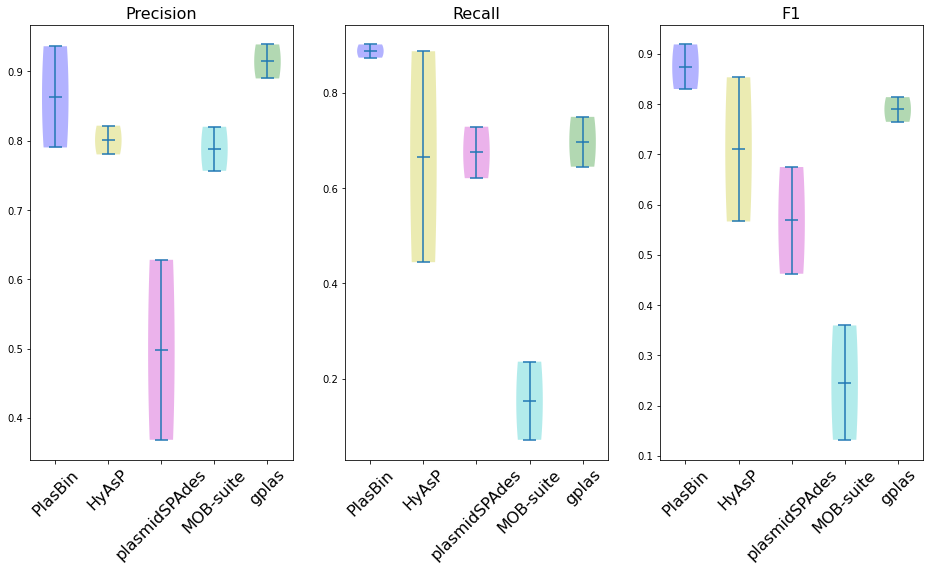

In [21]:
EFAECIUM_DF = ALL_DF.loc[ALL_DF['Species'] == 'E. faecium']
colors = ['b', 'y', 'm', 'c', 'g']
labels = ['','PlasBin', 'HyAsP', 'plasmidSPAdes', 'MOB-suite', 'gplas']
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
bplot1 = ax1.violinplot(EFAECIUM_DF[['Precision', 'greedy_Precision', 'plasmidspades_Precision', 'mobsuite_Precision', 'gplas_Precision']], showmeans=True)
ax1.set_title('Precision',fontsize=16)

bplot2 = ax2.violinplot(EFAECIUM_DF[['Recall', 'greedy_Recall', 'plasmidspades_Recall', 'mobsuite_Recall', 'gplas_Recall']], showmeans=True)
ax2.set_title('Recall',fontsize=16)
bplot3 = ax3.violinplot(EFAECIUM_DF[['F1', 'greedy_F1', 'plasmidspades_F1', 'mobsuite_F1', 'gplas_F1']], showmeans=True)
ax3.set_title('F1',fontsize=16)

for bplot in (bplot1, bplot2, bplot3):
    for pc, color in zip(bplot['bodies'], colors):
        pc.set_facecolor(color)

for ax in [ax1, ax2, ax3]:
    ax.set_xticklabels(labels, rotation=45, fontsize=16)

plt.show()
plt.close()

### E. coli

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


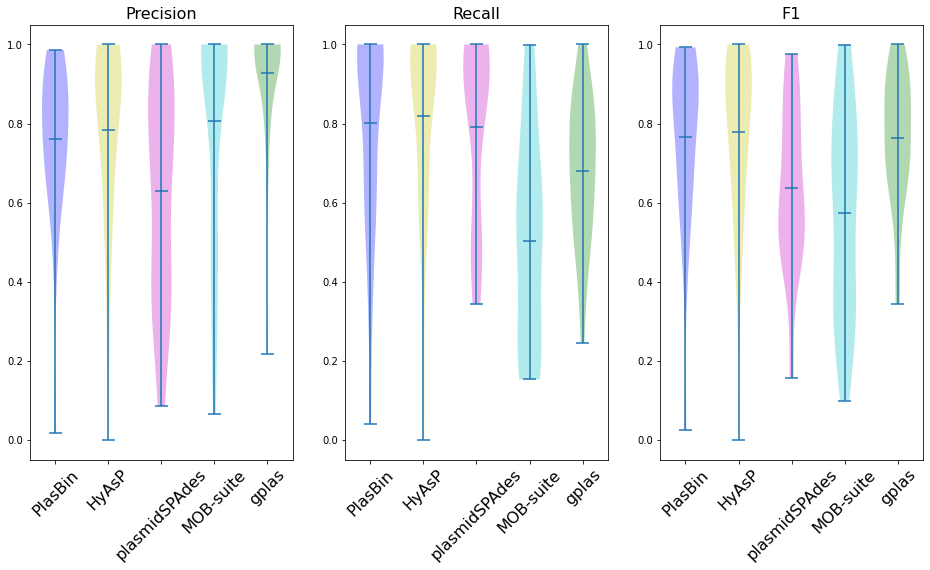

In [22]:
ECOLI_DF = ALL_DF.loc[ALL_DF['Species'] == 'E. coli']
colors = ['b', 'y', 'm', 'c', 'g']
labels = ['','PlasBin', 'HyAsP', 'plasmidSPAdes', 'MOB-suite', 'gplas']
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
bplot1 = ax1.violinplot(ECOLI_DF[['Precision', 'greedy_Precision', 'plasmidspades_Precision', 'mobsuite_Precision', 'gplas_Precision']], showmeans=True)
ax1.set_title('Precision',fontsize=16)

bplot2 = ax2.violinplot(ECOLI_DF[['Recall', 'greedy_Recall', 'plasmidspades_Recall', 'mobsuite_Recall', 'gplas_Recall']], showmeans=True)
ax2.set_title('Recall',fontsize=16)
bplot3 = ax3.violinplot(ECOLI_DF[['F1', 'greedy_F1', 'plasmidspades_F1', 'mobsuite_F1', 'gplas_F1']], showmeans=True)
ax3.set_title('F1',fontsize=16)

for bplot in (bplot1, bplot2, bplot3):
    for pc, color in zip(bplot['bodies'], colors):
        pc.set_facecolor(color)

for ax in [ax1, ax2, ax3]:
    ax.set_xticklabels(labels, rotation=45, fontsize=16)

plt.show()
plt.close()

### K. pneumoniae

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


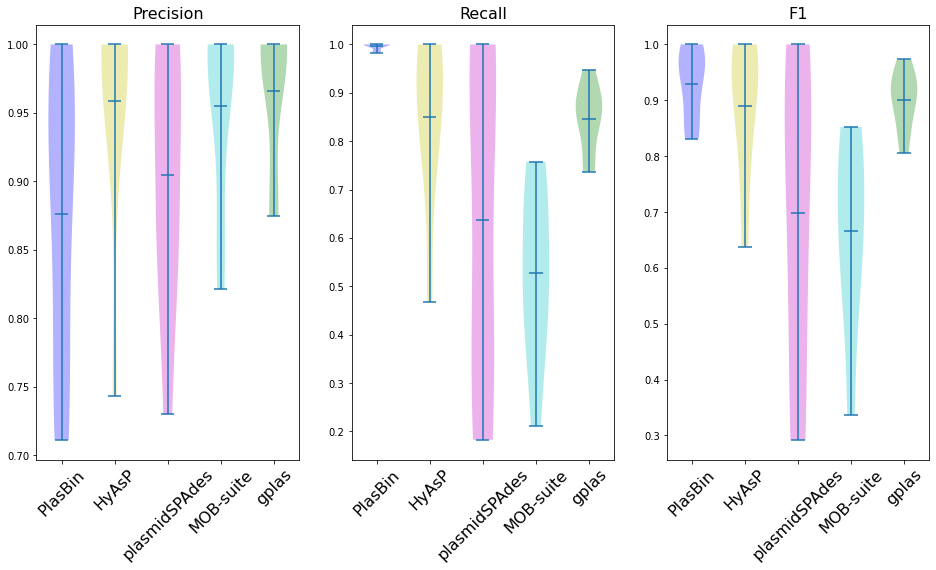

In [23]:
KPNEUMONIAE_DF = ALL_DF.loc[ALL_DF['Species'] == 'K. pneumoniae']
colors = ['b', 'y', 'm', 'c', 'g']
labels = ['','PlasBin', 'HyAsP', 'plasmidSPAdes', 'MOB-suite', 'gplas']
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
bplot1 = ax1.violinplot(KPNEUMONIAE_DF[['Precision', 'greedy_Precision', 'plasmidspades_Precision', 'mobsuite_Precision', 'gplas_Precision']], showmeans=True)
ax1.set_title('Precision',fontsize=16)

bplot2 = ax2.violinplot(KPNEUMONIAE_DF[['Recall', 'greedy_Recall', 'plasmidspades_Recall', 'mobsuite_Recall', 'gplas_Recall']], showmeans=True)
ax2.set_title('Recall',fontsize=16)
bplot3 = ax3.violinplot(KPNEUMONIAE_DF[['F1', 'greedy_F1', 'plasmidspades_F1', 'mobsuite_F1', 'gplas_F1']], showmeans=True)
ax3.set_title('F1',fontsize=16)

for bplot in (bplot1, bplot2, bplot3):
    for pc, color in zip(bplot['bodies'], colors):
        pc.set_facecolor(color)

for ax in [ax1, ax2, ax3]:
    ax.set_xticklabels(labels, rotation=45, fontsize=16)

plt.show()
plt.close()

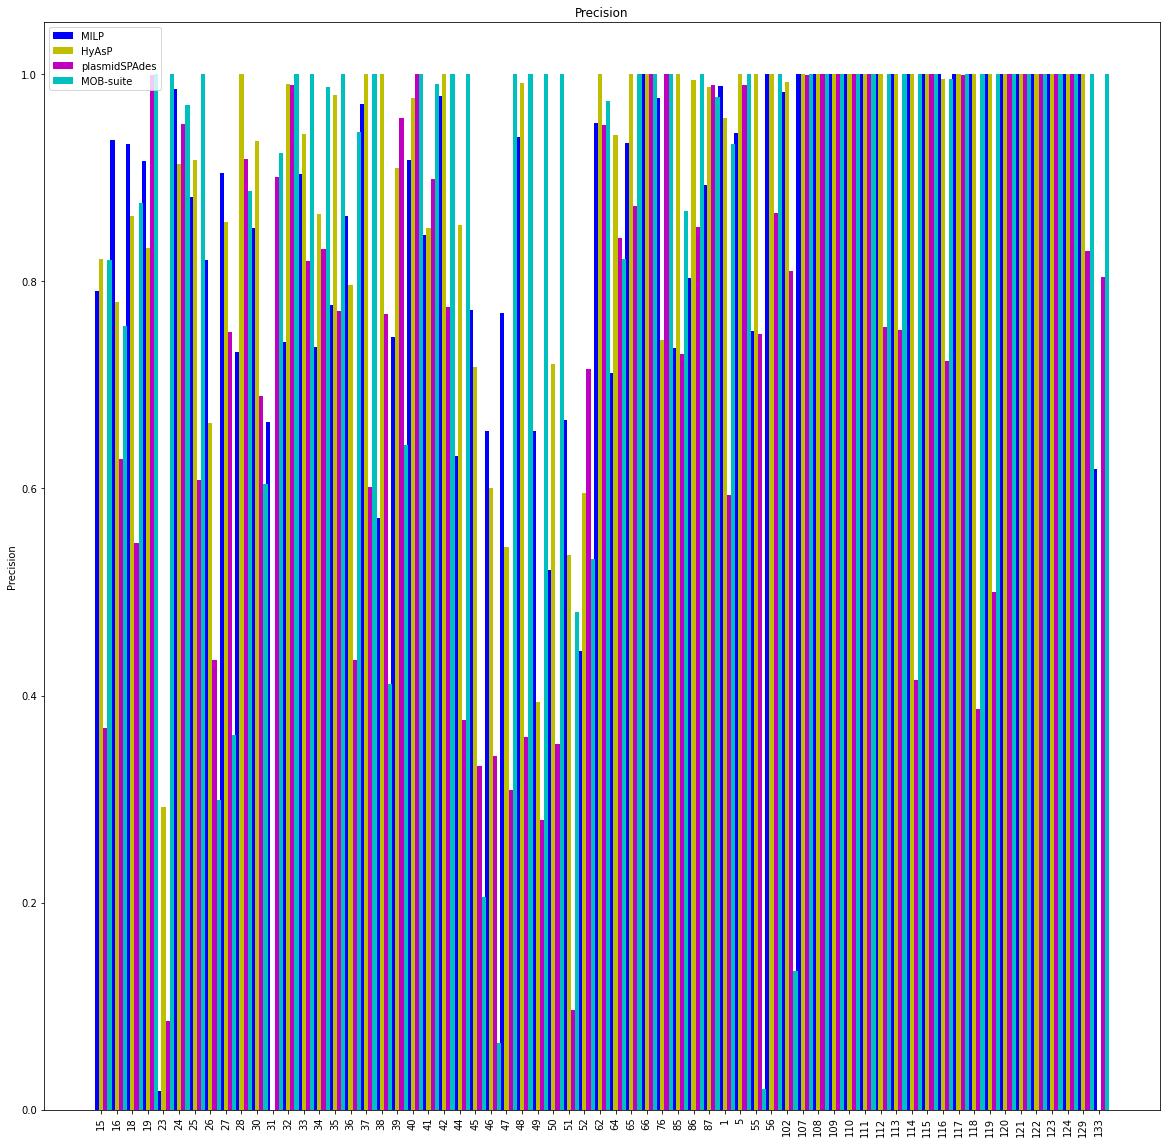

In [24]:
N = len(all_ids)
ind = np.arange(N)
width = 0.27

fig = plt.figure(figsize=(20,20))

axp = fig.add_subplot(111)

#ids = list(ids)
#ids = [k.split('_')[1] for k in ids]

pvals = ALL_DF['Precision'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='b')
gpvals = ALL_DF['greedy_Precision'].values.tolist()
rects2 = axp.bar(ind+width, gpvals, width, color='y')
ppvals = ALL_DF['plasmidspades_Precision'].values.tolist()
rects3 = axp.bar(ind+2*width, ppvals, width, color='m')
mpvals = ALL_DF['mobsuite_Precision'].values.tolist()
rects4 = axp.bar(ind+3*width, mpvals, width, color='c')

#gpvals = HYASP_PREC_DF['Precision_length'].values.tolist()
#rects3 = axp.bar(ind+2*width, tlvals, width, color='r')
#gtlvals = HYASP_PREC_DF['Length'].values.tolist()
#rects4 = axp.bar(ind+3*width, gpvals, width, color='b')
axp.set_ylabel('Precision')
axp.set_xticks(ind+width)
axp.set_xticklabels([(all_ids[i]) for i in range(N)])
axp.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), ('MILP', 'HyAsP', 'plasmidSPAdes', 'MOB-suite') )
plt.xticks(rotation=90)
plt.title("Precision")
plt.show()

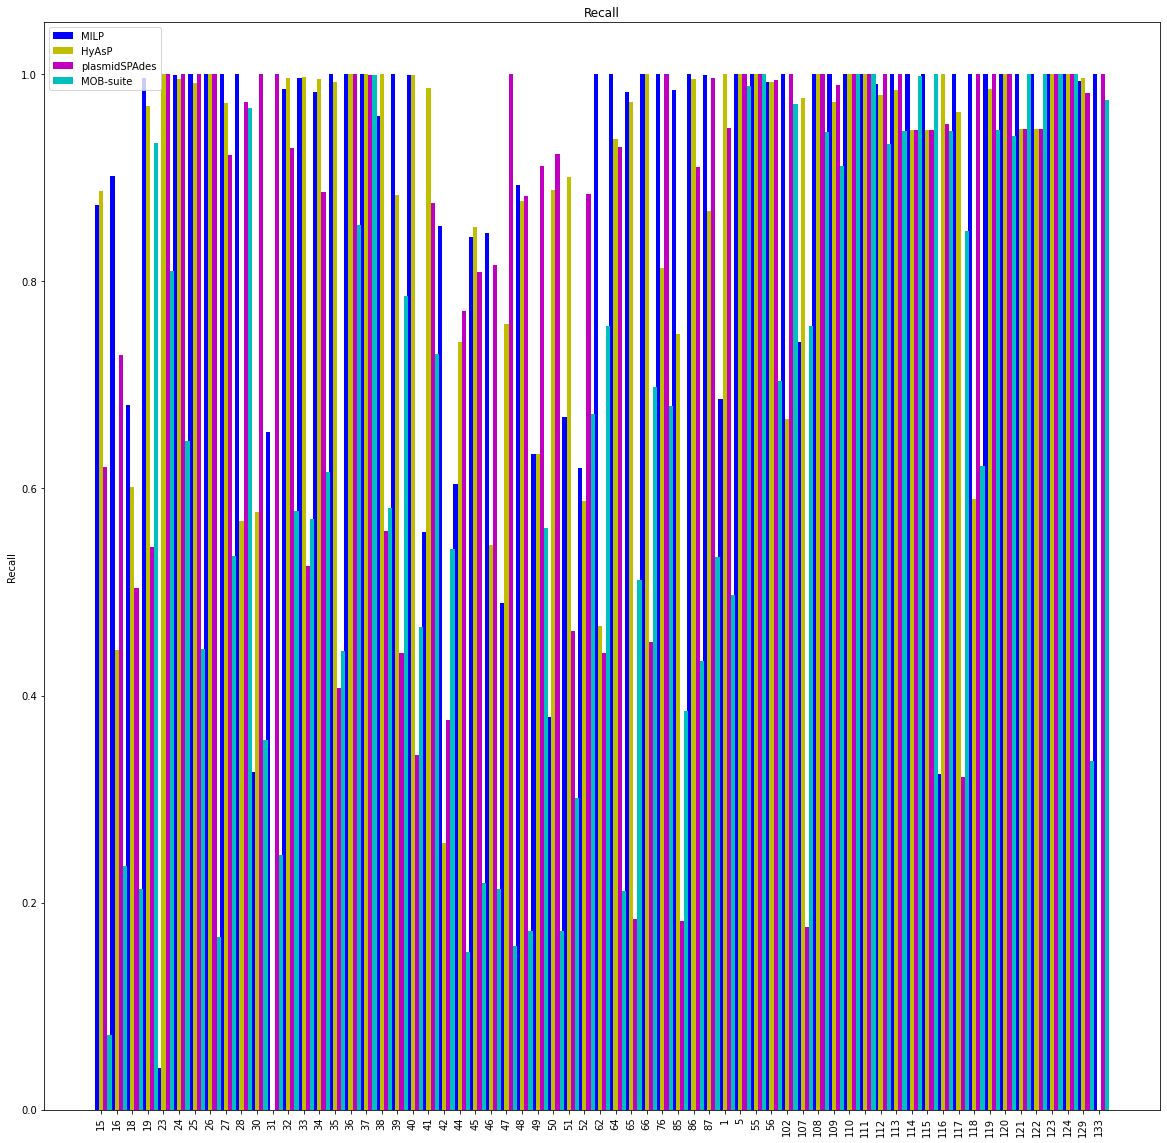

In [25]:
N = len(all_ids)
width = 0.27

fig = plt.figure(figsize=(20,20))

axp = fig.add_subplot(111)

#ids = list(ids)
#ids = [k.split('_')[1] for k in ids]

pvals = ALL_DF['Recall'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='b')
gpvals = ALL_DF['greedy_Recall'].values.tolist()
rects2 = axp.bar(ind+width, gpvals, width, color='y')
ppvals = ALL_DF['plasmidspades_Recall'].values.tolist()
rects3 = axp.bar(ind+2*width, ppvals, width, color='m')
mpvals = ALL_DF['mobsuite_Recall'].values.tolist()
rects4 = axp.bar(ind+3*width, mpvals, width, color='c')

#gpvals = HYASP_PREC_DF['Precision_length'].values.tolist()
#rects3 = axp.bar(ind+2*width, tlvals, width, color='r')
#gtlvals = HYASP_PREC_DF['Length'].values.tolist()
#rects4 = axp.bar(ind+3*width, gpvals, width, color='b')
axp.set_ylabel('Recall')
axp.set_xticks(ind+width)
axp.set_xticklabels([(all_ids[i]) for i in range(N)])
axp.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), ('MILP', 'HyAsP', 'plasmidSPAdes', 'MOB-suite') )
plt.xticks(rotation=90)
plt.title("Recall")
plt.show()

## Indiviudal comparison with other tools

### Comparison with HyAsP

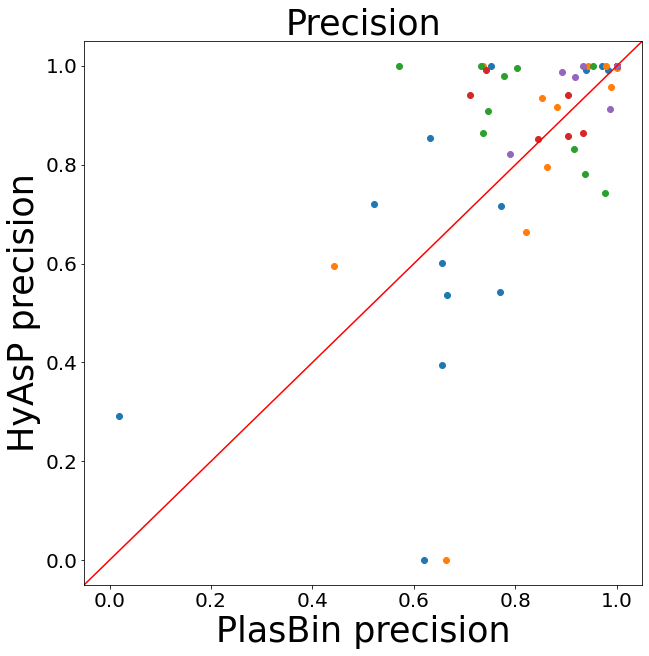

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ALL_DF.keys())
samples = list(ALL_DF.keys())
groups = ALL_DF.groupby('Category')
lengths = ['<100 kbp', '<200 kbp', '<300 kbp', '<400 kbp', '>400 kbp']
for name, group in groups:
    i = int(name)
    plt.scatter(group['Precision'], group['greedy_Precision'], label=lengths[i])
plt.axline([0, 0], [1, 1], color = 'r')    
#plt.legend(loc=[1.01,0.7],fontsize=20)
plt.title("Precision", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('PlasBin precision', fontsize=35)
plt.ylabel('HyAsP precision', fontsize=35)
plt.show()

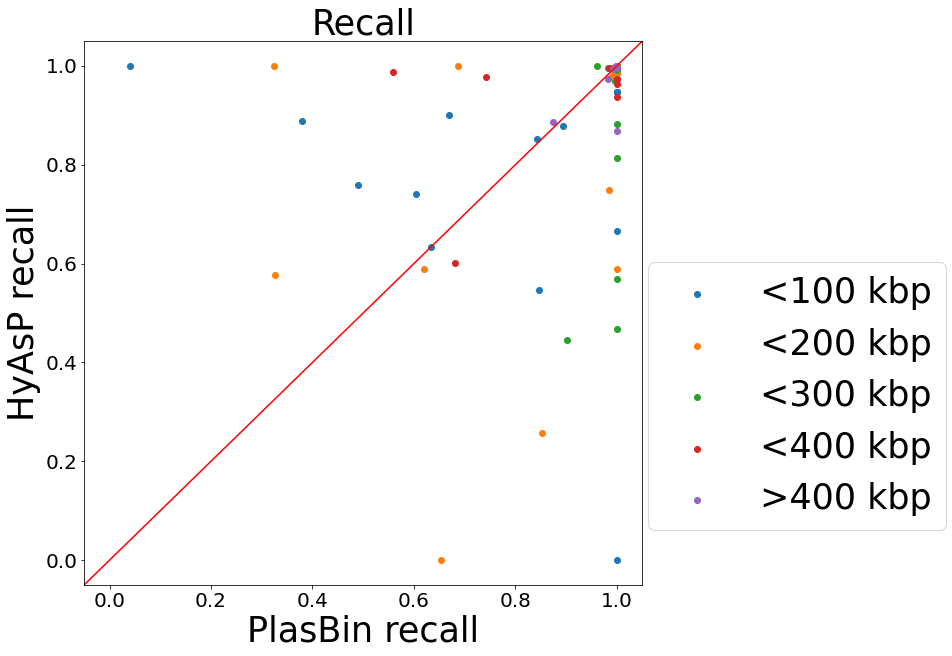

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ALL_DF.keys())
samples = list(ALL_DF.keys())
groups = ALL_DF.groupby('Category')
lengths = ['<100 kbp', '<200 kbp', '<300 kbp', '<400 kbp', '>400 kbp']
for name, group in groups:
    i = int(name)
    plt.scatter(group['Recall'], group['greedy_Recall'], label=lengths[i])
plt.axline([0, 0], [1, 1], color = 'r')    
plt.legend(loc=[1.01,0.1],fontsize=35)
plt.title("Recall", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('PlasBin recall', fontsize=35)
plt.ylabel('HyAsP recall', fontsize=35)
plt.show()

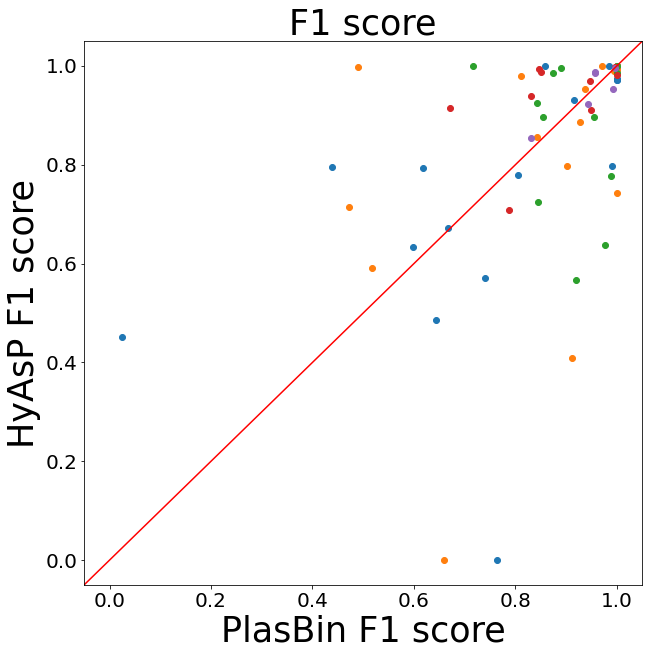

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ALL_DF.keys())
samples = list(ALL_DF.keys())
groups = ALL_DF.groupby('Category')
lengths = ['<100 kbp', '<200 kbp', '<300 kbp', '<400 kbp', '>400 kbp']
for name, group in groups:
    i = int(name)
    plt.scatter(group['F1'], group['greedy_F1'], label=lengths[i])
plt.axline([0, 0], [1, 1], color = 'r')    
#plt.legend(loc=[1.01,0.4],fontsize=35)
plt.title("F1 score", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('PlasBin F1 score', fontsize=35)
plt.ylabel('HyAsP F1 score', fontsize=35)
plt.show()

### Comparison with plasmidSPAdes

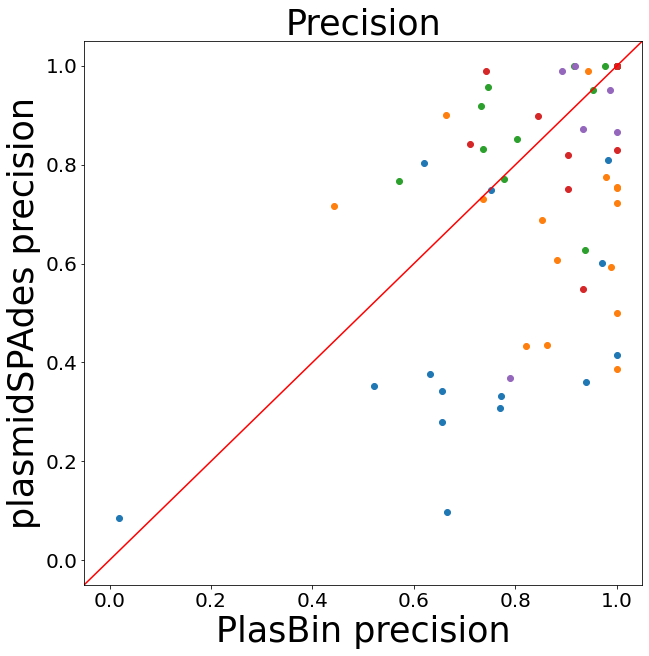

In [76]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ALL_DF.keys())
samples = list(ALL_DF.keys())
groups = ALL_DF.groupby('Category')
lengths = ['<100 kbp', '<200 kbp', '<300 kbp', '<400 kbp', '>400 kbp']
for name, group in groups:
    i = int(name)
    plt.scatter(group['Precision'], group['plasmidspades_Precision'], label=lengths[i])
plt.axline([0, 0], [1, 1], color = 'r')    
#plt.legend(loc=[1.01,0.7],fontsize=20)
plt.title("Precision", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('PlasBin precision', fontsize=35)
plt.ylabel('plasmidSPAdes precision', fontsize=35)
plt.show()

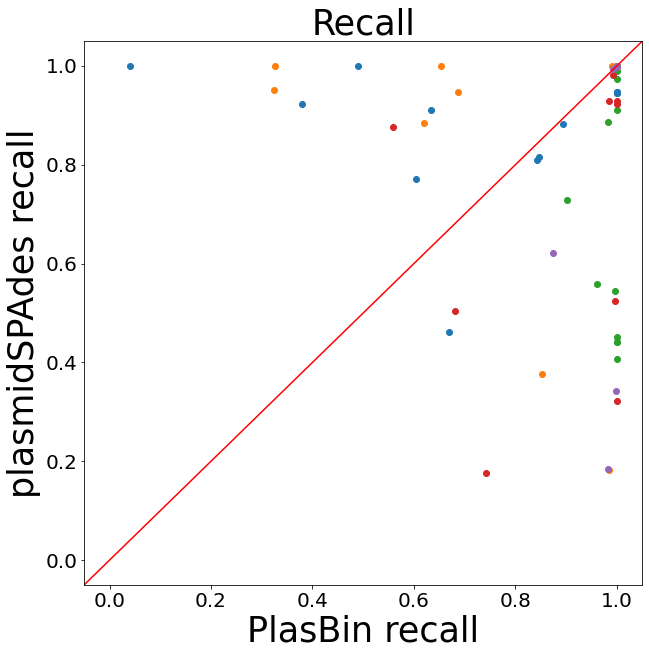

In [77]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ALL_DF.keys())
samples = list(ALL_DF.keys())
groups = ALL_DF.groupby('Category')
lengths = ['<100 kbp', '<200 kbp', '<300 kbp', '<400 kbp', '>400 kbp']
for name, group in groups:
    i = int(name)
    plt.scatter(group['Recall'], group['plasmidspades_Recall'], label=lengths[i])
plt.axline([0, 0], [1, 1], color = 'r')    
#plt.legend(loc=[1.01,0.7],fontsize=20)
plt.title("Recall", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('PlasBin recall', fontsize=35)
plt.ylabel('plasmidSPAdes recall', fontsize=35)
plt.show()

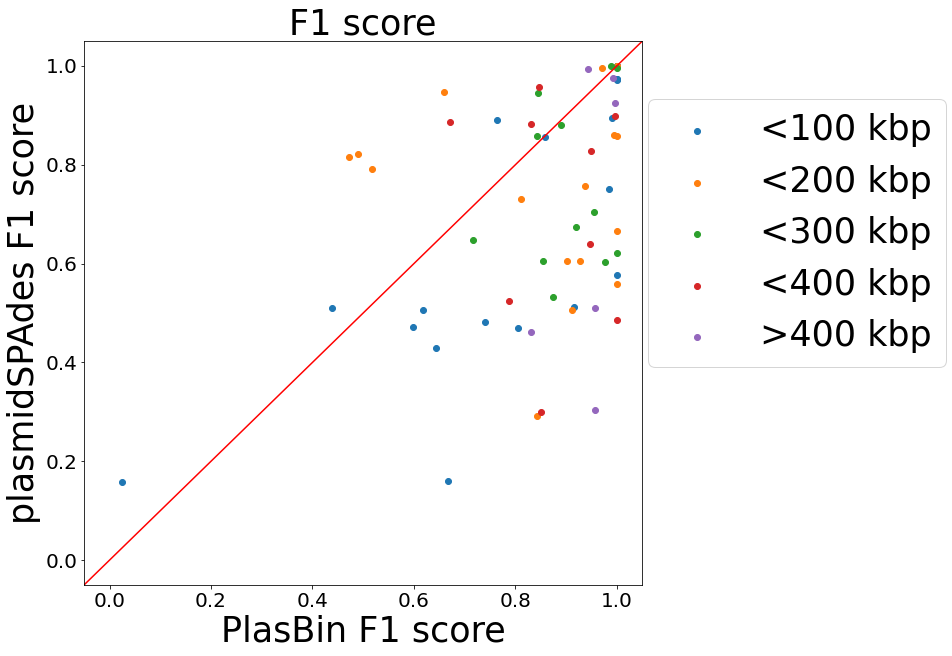

In [78]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ALL_DF.keys())
samples = list(ALL_DF.keys())
groups = ALL_DF.groupby('Category')
lengths = ['<100 kbp', '<200 kbp', '<300 kbp', '<400 kbp', '>400 kbp']
for name, group in groups:
    i = int(name)
    plt.scatter(group['F1'], group['plasmidspades_F1'], label=lengths[i])
plt.axline([0, 0], [1, 1], color = 'r')    
plt.legend(loc=[1.01,0.4],fontsize=35)
plt.title("F1 score", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('PlasBin F1 score', fontsize=35)
plt.ylabel('plasmidSPAdes F1 score', fontsize=35)
plt.show()

### Comparison with MOB-suite

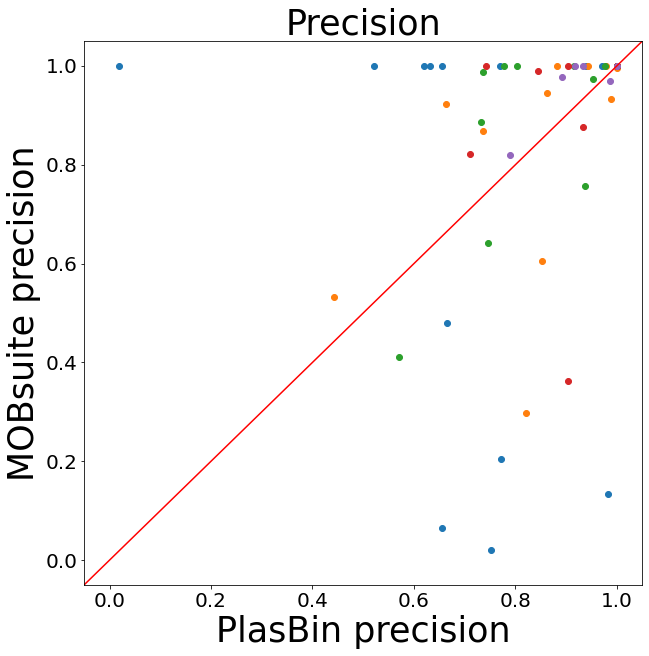

In [79]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ALL_DF.keys())
samples = list(ALL_DF.keys())
groups = ALL_DF.groupby('Category')
lengths = ['<100 kbp', '<200 kbp', '<300 kbp', '<400 kbp', '>400 kbp']
for name, group in groups:
    i = int(name)
    plt.scatter(group['Precision'], group['mobsuite_Precision'], label=lengths[i])
plt.axline([0, 0], [1, 1], color = 'r')    
#plt.legend(loc=[1.01,0.7],fontsize=20)
plt.title("Precision", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('PlasBin precision', fontsize=35)
plt.ylabel('MOBsuite precision', fontsize=35)
plt.show()

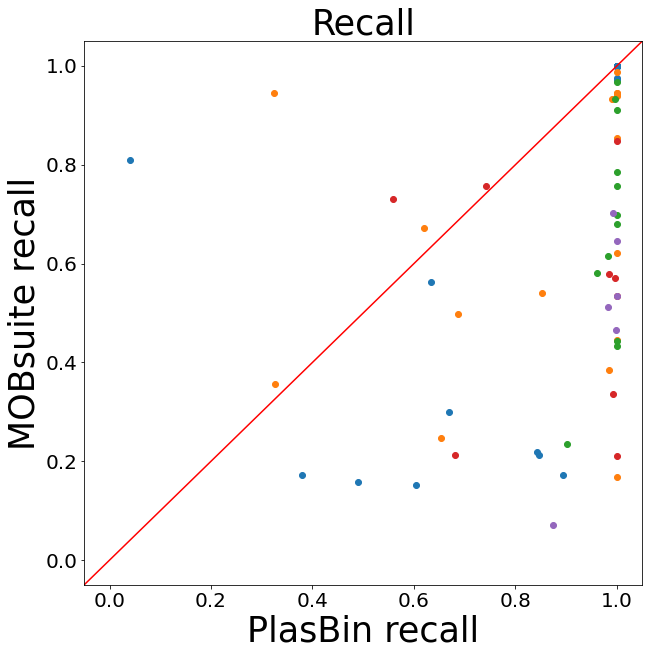

In [80]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ALL_DF.keys())
samples = list(ALL_DF.keys())
groups = ALL_DF.groupby('Category')
lengths = ['<100 kbp', '<200 kbp', '<300 kbp', '<400 kbp', '>400 kbp']
for name, group in groups:
    i = int(name)
    plt.scatter(group['Recall'], group['mobsuite_Recall'], label=lengths[i])
plt.axline([0, 0], [1, 1], color = 'r')    
#plt.legend(loc=[1.01,0.7],fontsize=20)
plt.title("Recall", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('PlasBin recall', fontsize=35)
plt.ylabel('MOBsuite recall', fontsize=35)
plt.show()

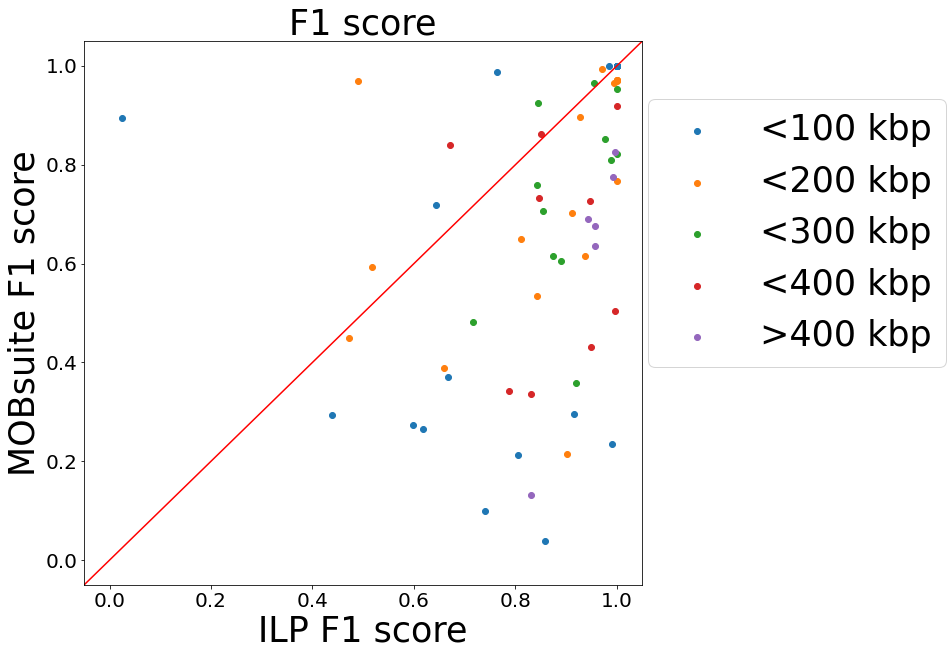

In [81]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ALL_DF.keys())
samples = list(ALL_DF.keys())
groups = ALL_DF.groupby('Category')
lengths = ['<100 kbp', '<200 kbp', '<300 kbp', '<400 kbp', '>400 kbp']
for name, group in groups:
    i = int(name)
    plt.scatter(group['F1'], group['mobsuite_F1'], label=lengths[i])
plt.axline([0, 0], [1, 1], color = 'r')    
plt.legend(loc=[1.01,0.4],fontsize=35)
plt.title("F1 score", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('ILP F1 score', fontsize=35)
plt.ylabel('MOBsuite F1 score', fontsize=35)
plt.show()

### Comparison with gplas

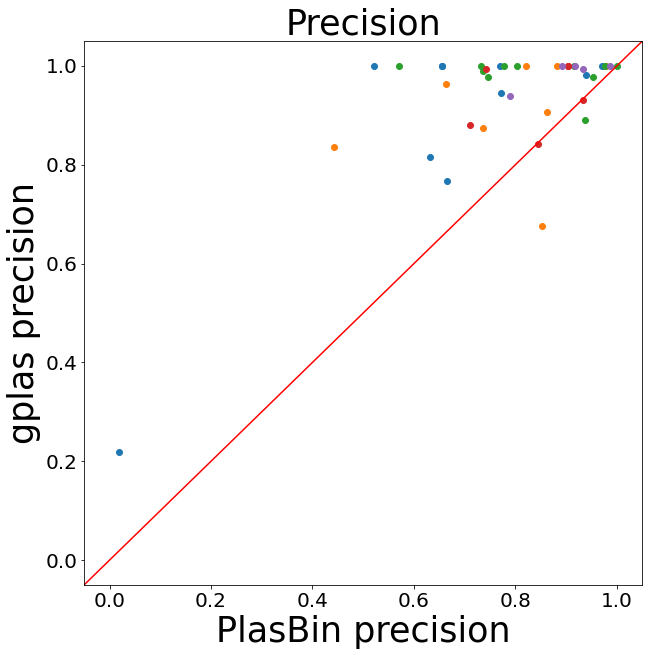

In [82]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(THREE_SPECIES_DF.keys())
samples = list(THREE_SPECIES_DF.keys())
groups = THREE_SPECIES_DF.groupby('Category')
lengths = ['<100 kbp', '<200 kbp', '<300 kbp', '<400 kbp', '>400 kbp']
for name, group in groups:
    i = int(name)
    plt.scatter(group['Precision'], group['gplas_Precision'], label=lengths[i])
plt.axline([0, 0], [1, 1], color = 'r')    
#plt.legend(loc=[1.01,0.7],fontsize=20)
plt.title("Precision", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('PlasBin precision', fontsize=35)
plt.ylabel('gplas precision', fontsize=35)
plt.show()

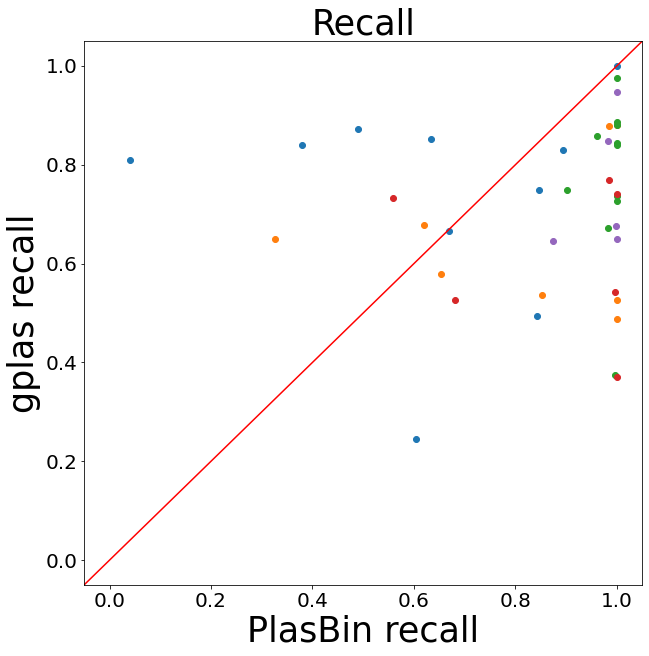

In [83]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(THREE_SPECIES_DF.keys())
samples = list(THREE_SPECIES_DF.keys())
groups = THREE_SPECIES_DF.groupby('Category')
lengths = ['<100 kbp', '<200 kbp', '<300 kbp', '<400 kbp', '>400 kbp']
for name, group in groups:
    i = int(name)
    plt.scatter(group['Recall'], group['gplas_Recall'], label=lengths[i])
plt.axline([0, 0], [1, 1], color = 'r')    
#plt.legend(loc=[1.01,0.7],fontsize=20)
plt.title("Recall", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('PlasBin recall', fontsize=35)
plt.ylabel('gplas recall', fontsize=35)
plt.show()

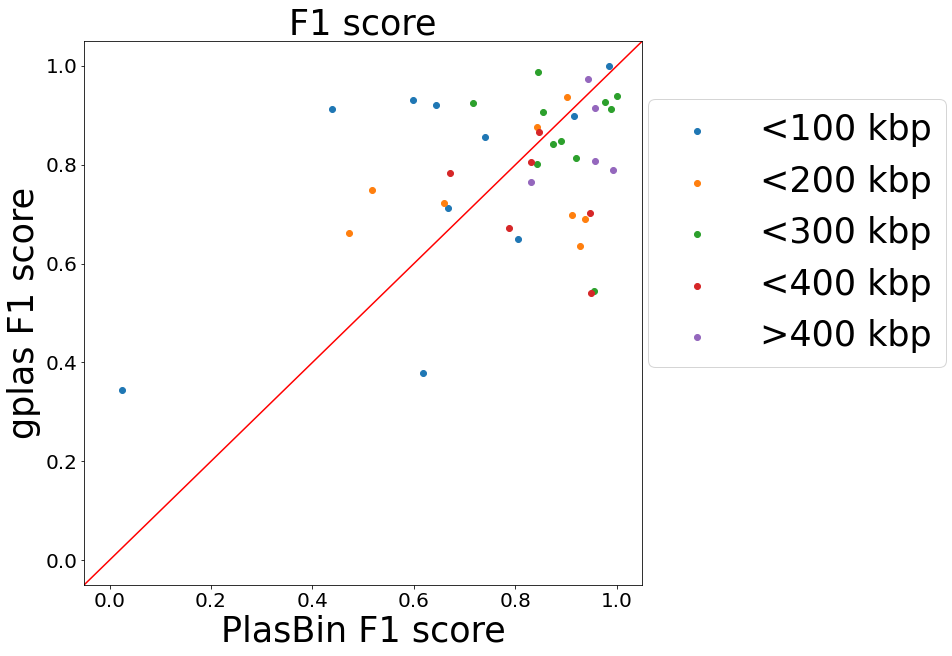

In [84]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(THREE_SPECIES_DF.keys())
samples = list(THREE_SPECIES_DF.keys())
groups = THREE_SPECIES_DF.groupby('Category')
lengths = ['<100 kbp', '<200 kbp', '<300 kbp', '<400 kbp', '>400 kbp']
for name, group in groups:
    i = int(name)
    plt.scatter(group['F1'], group['gplas_F1'], label=lengths[i])
plt.axline([0, 0], [1, 1], color = 'r')    
plt.legend(loc=[1.01,0.4],fontsize=35)
plt.title("F1 score", fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('PlasBin F1 score', fontsize=35)
plt.ylabel('gplas F1 score', fontsize=35)
plt.show()

## Correct vs incorrect predictions - by length

### By sample: Precision by cumulative length for all plasmids in the sample

In [94]:
MILP_PREC_DF = pd.DataFrame.from_dict(MILP_PREC).T
HYASP_PREC_DF= pd.DataFrame.from_dict(HYASP_PREC).T


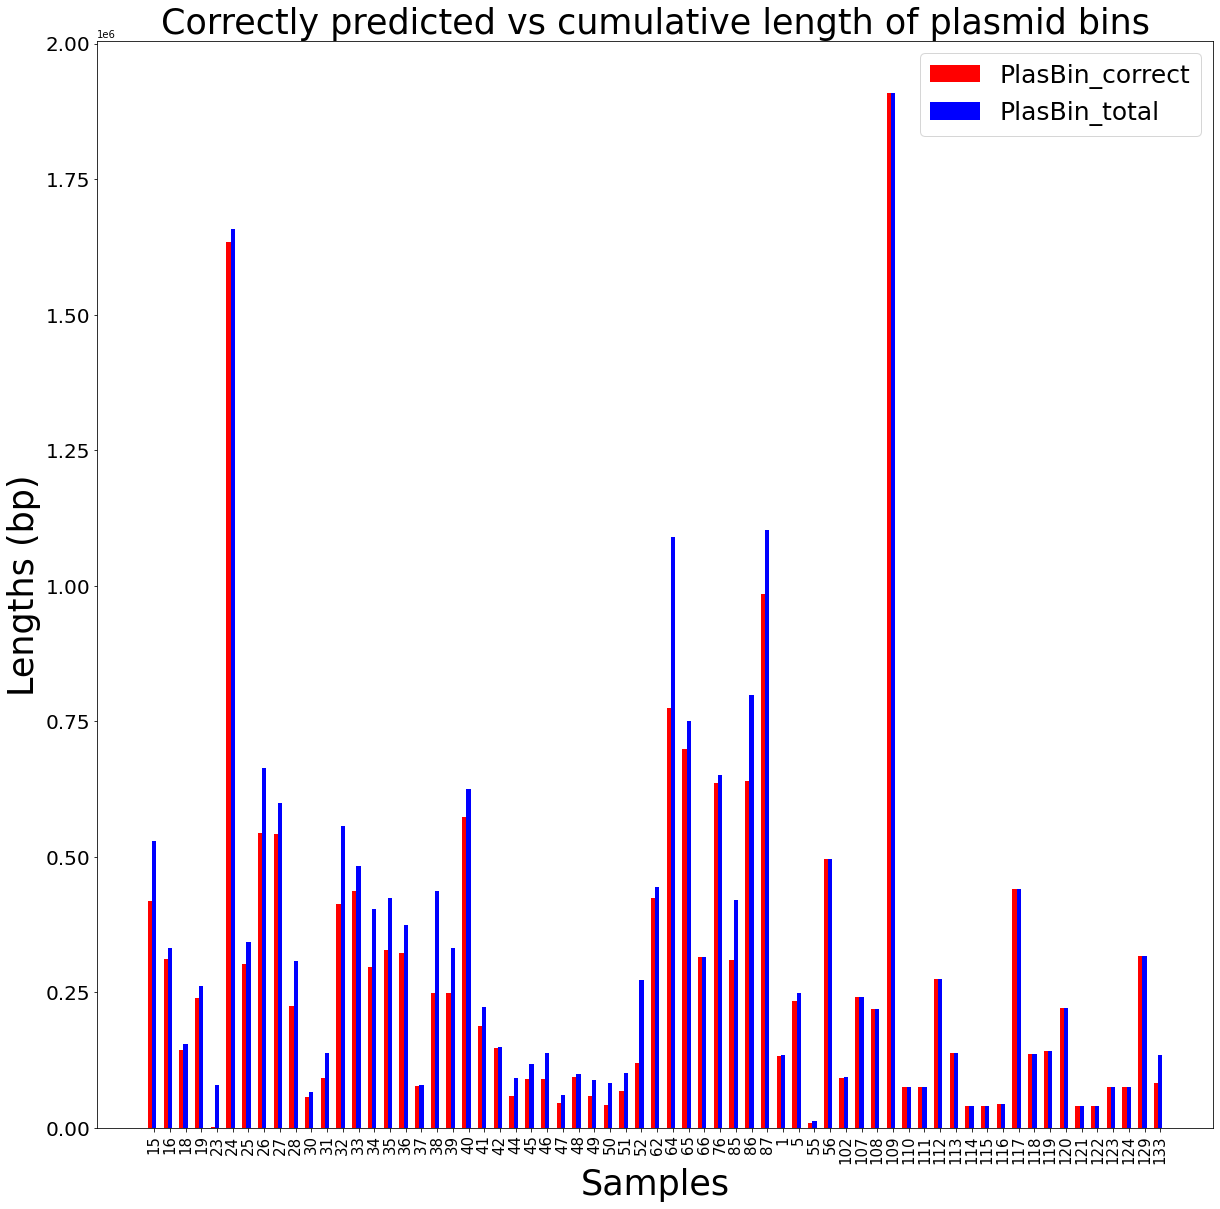

In [96]:
N = len(all_ids)
ind = np.arange(N)
width = 0.27

fig = plt.figure(figsize=(20,20))

axp = fig.add_subplot(111)

#ids = list(MILP_PREC.keys())
#ids = [k.split('_')[1] for k in ids]

pvals = MILP_PREC_DF['Precision_length'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='r')
tlvals = MILP_PREC_DF['Length'].values.tolist()
rects2 = axp.bar(ind+width, tlvals, width, color='b')

#gpvals = HYASP_PREC_DF['Precision_length'].values.tolist()
#rects3 = axp.bar(ind+2*width, tlvals, width, color='r')
#gtlvals = HYASP_PREC_DF['Length'].values.tolist()
#rects4 = axp.bar(ind+3*width, gpvals, width, color='b')
axp.set_ylabel('Lengths (bp)',fontsize=35)
axp.set_xlabel('Samples',fontsize=35)
axp.set_xticks(ind+width)
#axp.set_xticksize(20)
axp.set_xticklabels([(all_ids[i]) for i in range(N)])
axp.legend( (rects1[0], rects2[0]), ('PlasBin_correct', 'PlasBin_total'), fontsize=25 )
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=20)
plt.title("Correctly predicted vs cumulative length of plasmid bins",fontsize=35)
plt.show()

### By sample: Recall by cumulative length for all true plasmids in the sample

In [46]:
MILP_REC_DF = pd.DataFrame.from_dict(MILP_REC).T
HYASP_REC_DF= pd.DataFrame.from_dict(HYASP_REC).T

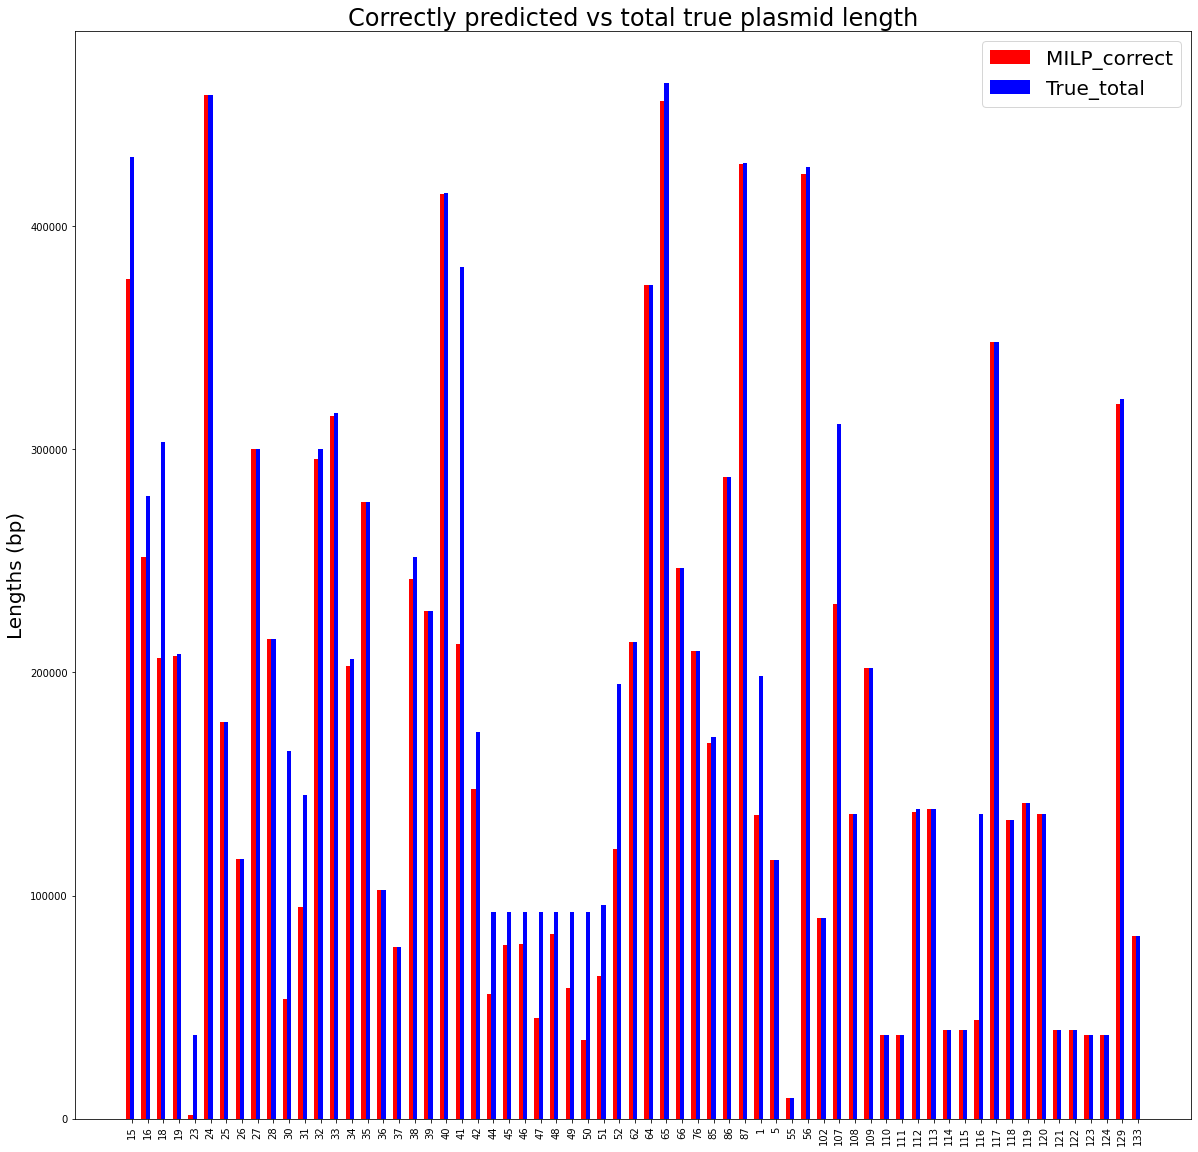

In [47]:
N = len(all_ids)
ind = np.arange(N)
width = 0.27

fig = plt.figure(figsize=(20,20))

axp = fig.add_subplot(111)

#ids = list(MILP_REC.keys())
#ids = [k.split('_')[1] for k in ids]

pvals = MILP_REC_DF['Recall_length'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='r')
tlvals = MILP_REC_DF['Length'].values.tolist()
rects2 = axp.bar(ind+width, tlvals, width, color='b')

#gpvals = HYASP_PREC_DF['Precision_length'].values.tolist()
#rects3 = axp.bar(ind+2*width, tlvals, width, color='r')
#gtlvals = HYASP_PREC_DF['Length'].values.tolist()
#rects4 = axp.bar(ind+3*width, gpvals, width, color='b')
axp.set_ylabel('Lengths (bp)',fontsize=20)
axp.set_xticks(ind+width)
axp.set_xticklabels([(all_ids[i]) for i in range(N)])
axp.legend( (rects1[0], rects2[0]), ('MILP_correct', 'True_total'), fontsize=20 )
plt.xticks(rotation=90)
plt.title("Correctly predicted vs total true plasmid length", fontsize=24)
plt.show()

### By plasmid: Precision by length for individual plasmid

In [48]:
MILP_PREC_PLASMID_DF = pd.DataFrame.from_dict(MILP_PREC_PLASMID).T
HYASP_PREC_PLASMID_DF= pd.DataFrame.from_dict(HYASP_PREC_PLASMID).T

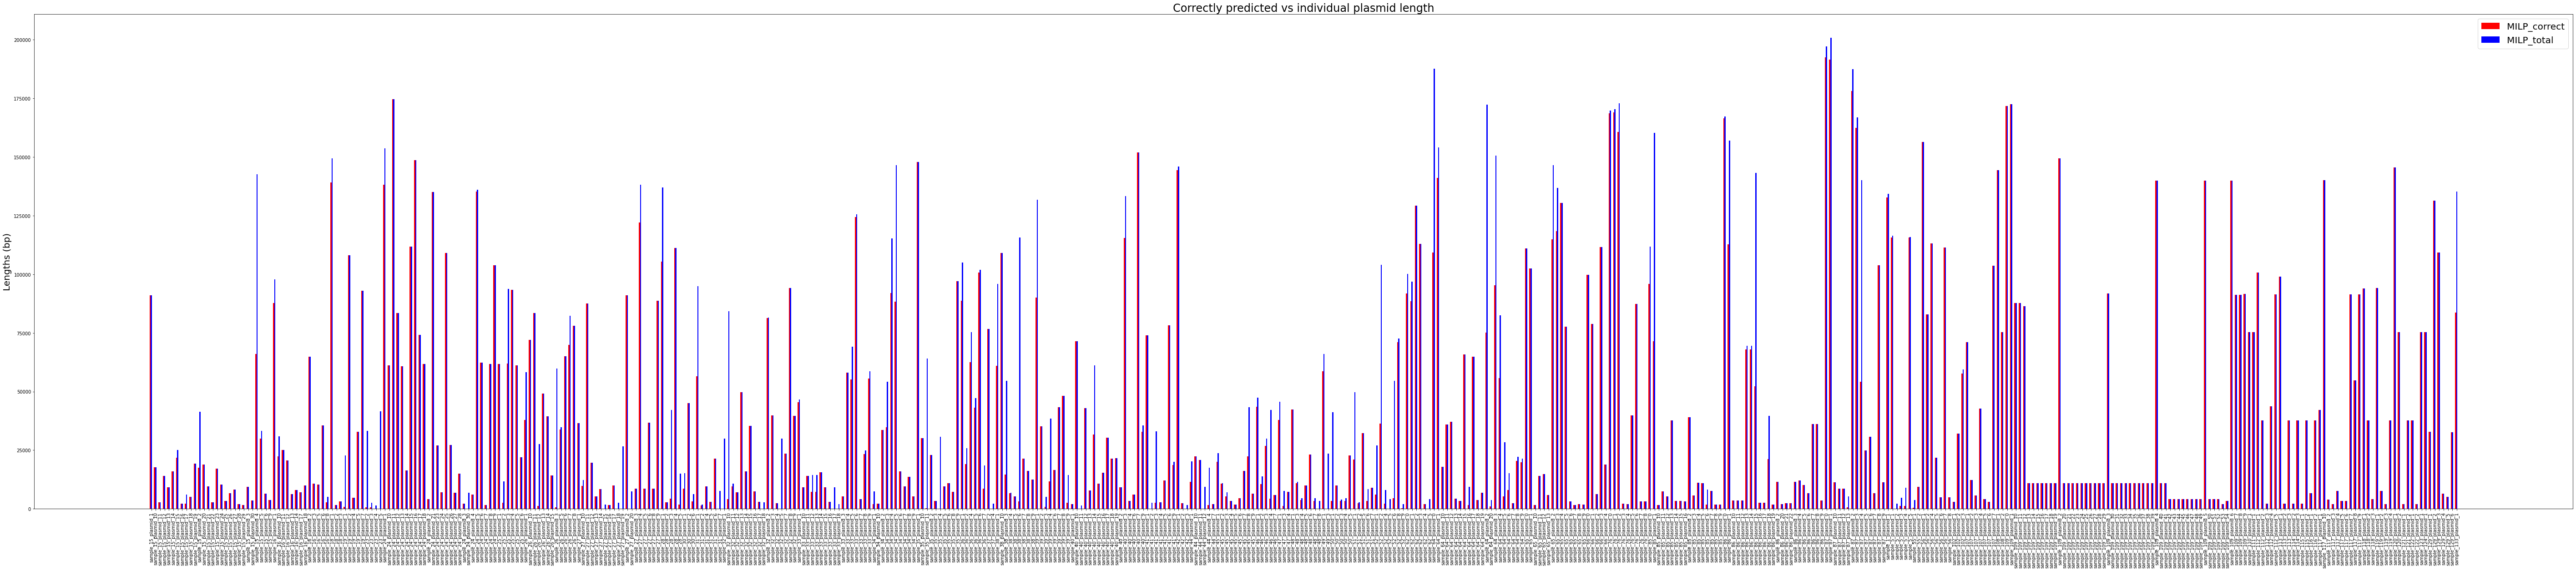

In [49]:
N = len(MILP_PREC_PLASMID)
ind = np.arange(N)
width = 0.27

fig = plt.figure(figsize=(100,20))

axp = fig.add_subplot(111)

ids = list(MILP_PREC_PLASMID.keys())
#ids = [k.split('_')[1] for k in ids]

pvals = MILP_PREC_PLASMID_DF['Precision_length'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='r')
tlvals = MILP_PREC_PLASMID_DF['Length'].values.tolist()
rects2 = axp.bar(ind+width, tlvals, width, color='b')

#gpvals = HYASP_PREC_DF['Precision_length'].values.tolist()
#rects3 = axp.bar(ind+2*width, tlvals, width, color='r')
#gtlvals = HYASP_PREC_DF['Length'].values.tolist()
#rects4 = axp.bar(ind+3*width, gpvals, width, color='b')
axp.set_ylabel('Lengths (bp)', fontsize=20)
axp.set_xticks(ind+width)
axp.set_xticklabels([(ids[i]) for i in range(len(ids))])
axp.legend( (rects1[0], rects2[0]), ('MILP_correct', 'MILP_total'), fontsize=20 )
plt.xticks(rotation=90)
plt.title("Correctly predicted vs individual plasmid length", fontsize=24)
plt.show()

In [50]:
MILP_PREC_PLASMID_DF 

,Length,Sample,Precision_length,Precision,Gene_density
sample_15_plasmid_1,91082,15,91082.0,1.0,0.830603
sample_15_plasmid_10,17817,15,17817.0,1.0,0.823652
sample_15_plasmid_11,2749,15,2738.999138,0.996362,0.425609
sample_15_plasmid_12,14049,15,14038.997112,0.999288,0.761122
sample_15_plasmid_13,9164,15,9164.0,1.0,0.8433
...,...,...,...,...,...
sample_129_plasmid_3,109203,129,109203.0,1.0,0.815939
sample_129_plasmid_4,6402,129,6402.0,1.0,0.837082
sample_129_plasmid_5,5170,129,5167.0014,0.99942,0.868859
sample_129_plasmid_6,32681,129,32681.0,1.0,0.883847


## Scatterplots for precision

### Precision vs predicted length

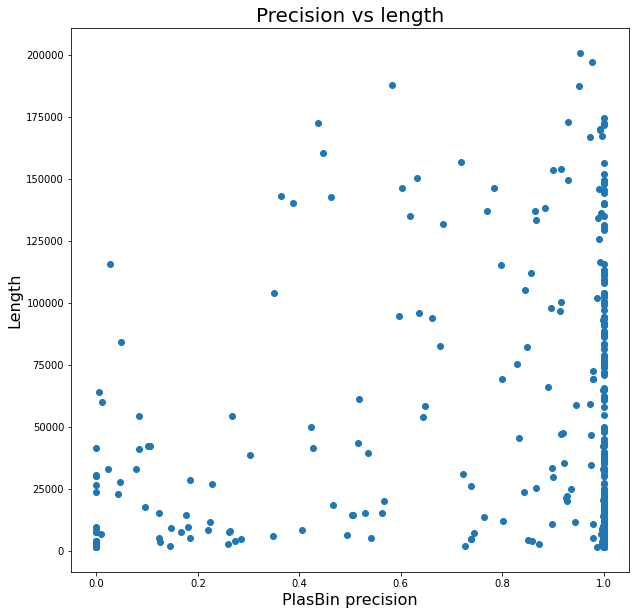

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
#ncolors = len(MILP_PREC.keys())
#samples = list(ALL_DF.keys())
#groups = MILP_PREC_PLASMID_DF.groupby('Sample')
#for name, group in groups:
plt.scatter(MILP_PREC_PLASMID_DF['Precision'], MILP_PREC_PLASMID_DF['Length'])

#plt.legend(loc=[1.01,0.3])
plt.title("Precision vs length", fontsize=20)
plt.xlabel('PlasBin precision', fontsize=16)
plt.ylabel('Length', fontsize=16)
plt.show()

### Precision vs order of output

In [102]:
#fig, ax = plt.subplots(figsize=(10,10))
#ncolors = len(ALL_DF.keys())
#samples = list(ALL_DF.keys())
#groups = ALL_DF.groupby('Category')
#for name, group in groups:
#plt.scatter(MILP_PREC_PLASMID_DF['Order'], MILP_PREC_PLASMID_DF['Precision'])

#plt.legend(loc=[1.01,0.3])
#plt.title("Order of output vs Precision", fontsize=20)
#plt.xlabel('Order of output', fontsize=16)
#plt.ylabel('ILP Precision', fontsize=16)
#plt.show()

### Precision vs gene density

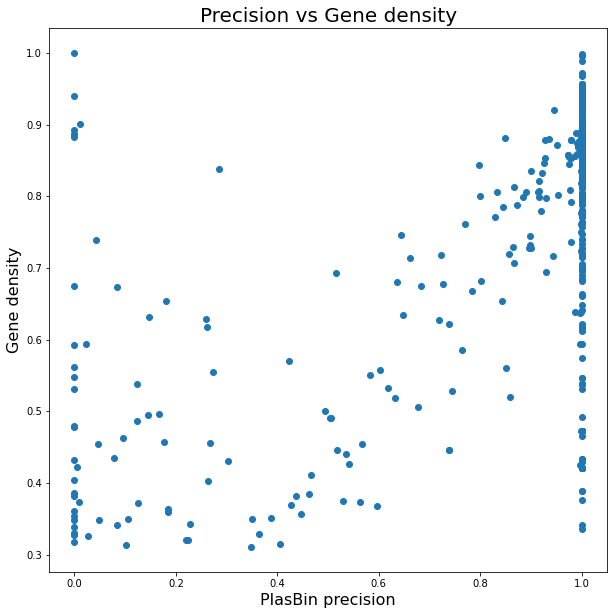

In [52]:
fig, ax = plt.subplots(figsize=(10,10))
#ncolors = len(ALL_DF.keys())
#samples = list(ALL_DF.keys())
#groups = ALL_DF.groupby('Category')
#for name, group in groups:
plt.scatter(MILP_PREC_PLASMID_DF['Precision'], MILP_PREC_PLASMID_DF['Gene_density'])

#plt.legend(loc=[1.01,0.3])
plt.title("Precision vs Gene density", fontsize=20)
plt.xlabel('PlasBin precision', fontsize=16)
plt.ylabel('Gene density', fontsize=16)
plt.show()

In [105]:
len(TP_LENGTH)

88